In [1]:
# import argparse
import datetime
import numpy as np
import itertools
import torch
from SAC import Environment, SAC
from torch.utils.tensorboard import SummaryWriter

from replay_memory import ReplayMemory

from ROMWithMSE2C import ROMWithE2C

# from pcc_model import PCC
from data_preprocessing import *

<Figure size 640x480 with 0 Axes>

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
output_dir = './saved_models/'

data_dir = 'data/'
state_file = 'states_norm_slt'
ctrl_file = 'controls_norm_slt'
yobs_file = 'rate_norm_slt'

state_data = state_file + '.mat'
ctrl_data = ctrl_file + '.mat'
yobs_data = yobs_file + '.mat'
cond = 'SC'   # standard condition for rates

In [4]:
nsteps = 2
_, _, _, _, _, num_t_slt, Nx, Ny, num_well, num_prod, num_inj = prepare_data(nsteps, data_dir, state_data, ctrl_data, yobs_data, cond)

(600, 21, 64, 64)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [5]:
n_channels = 2
method = 'E2C'
ode_steps = 0

#################### model specification ##################
learning_rate = 2e-4
latent_dim = 20

u_dim = num_well  # control dimension, gaussian 9 wells

input_shape = (n_channels, Nx, Ny)
perm_shape = (1, Nx, Ny)
prod_loc_shape = (num_well, 2)

In [6]:
epoch = 200
num_train = 9000
num_eval = 3000
encoder_file = output_dir + 'e2co_encoder_dt_'+'_nt%d_l%d_lr%.0e_ep%d_steps%d_cond%s.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps, cond)
decoder_file = output_dir + 'e2co_decoder_dt_'+'_nt%d_l%d_lr%.0e_ep%d_steps%d_cond%s.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps, cond)
transition_file = output_dir + 'e2co_transition_dt_' +'_nt%d_l%d_lr%.0e_ep%d_steps%d_cond%s.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps, cond)

In [7]:
my_rom = ROMWithE2C(latent_dim, 
                    u_dim, num_prod, num_inj, 
                    input_shape, 
                    perm_shape, 
                    prod_loc_shape, 
                    learning_rate,
                    method, 
                    ode_steps,
                    nsteps, 
                    sigma=0.0).to(device)

In [8]:
my_rom.model.load_weights_from_file(encoder_file, decoder_file, transition_file)

In [9]:
hf_r = h5py.File(data_dir + state_data, 'r')
sat = torch.tensor(np.array(hf_r.get('Mole_frac_norm_slt')).transpose((3,2,1,0)), dtype=torch.float32)
pres = torch.tensor(np.array(hf_r.get('Psim_norm_slt')).transpose((3,2,1,0)) , dtype=torch.float32)
hf_r.close()

In [10]:
sat_t_seq = sat[0:1, 0:1, ...].to(device)
pres_t_seq = pres[0:1, 0:1, ...].to(device)

state_t_seq = torch.cat((sat_t_seq, pres_t_seq),dim=1)

In [11]:
z0 = my_rom.model.encoder(state_t_seq)

In [12]:
# Agent
agent = SAC(latent_dim, u_dim)

In [13]:
#Tesnorboard
writer = SummaryWriter('runs/{}_SAC_{}_{}_{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"), 'ROM_RL', 'Deterministic', "autotune" if False else ""))

In [14]:
# Memory
memory = ReplayMemory(10000, 123456)

In [15]:
state = z0
# ROM based Enviroment
env = Environment(state, num_t_slt, num_prod, num_inj, my_rom)

In [16]:
# Training Loop
# batch_size = 256
batch_size = 256
total_numsteps = 0
updates = 0
updates_per_step = 1
total_episodes = 500
max_steps = 20

max_reward = 0
# eval = True
# for i_episode in itertools.count(1):
for i_episode in range(total_episodes):
    episode_reward = 0
    episode_steps = 0
    done = False
    state = env.reset(z0)
    
    # while not done:
    for j in range(max_steps):
        # if total_numsteps<2000:
        if total_numsteps<0:
            action = env.sample_action()  # Sample random action    --- exploration
        else:
            action = agent.select_action(state)  # Sample action from policy   --- exploitation

        # print(episode_steps)
        next_state, reward, done  = env.step(action) # Step
        
        # print(next_state)

        # Ignore the "done" signal if it comes from hitting the time horizon.
        # (https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py)
        # mask = 1 if episode_steps == num_t_slt else float(not done))

        # memory.push(state, action, reward, next_state, mask) # Append transition to memory
        memory.push(state, action, reward, next_state)
        
        if len(memory) > batch_size:
            # Number of updates per step in environment
            for i in range(updates_per_step):
                # Update parameters of all the networks
                critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, batch_size, updates)
                # critic_1_loss, critic_2_loss, ent_loss, alpha = agent.update_critic_parameters(memory, batch_size, updates)
                # policy_loss = agent.update_policy_parameters(memory, batch_size, updates)
                writer.add_scalar('loss/critic_1', critic_1_loss, updates)
                writer.add_scalar('loss/critic_2', critic_2_loss, updates)
                writer.add_scalar('loss/policy', policy_loss, updates)
                writer.add_scalar('loss/entropy_loss', ent_loss, updates)
                writer.add_scalar('entropy_temprature/alpha', alpha, updates)
                updates += 1
                
        state = next_state
        episode_steps += 1
        total_numsteps += 1
        episode_reward += reward

    # if total_numsteps > num_t_slt:
    #     break

    writer.add_scalar('reward/train', episode_reward.detach().cpu().numpy(), i_episode)
    if i_episode % 2 == 0:
        print("Episode: {}, total numsteps: {}, episode steps: {}, reward: {}".format(i_episode, total_numsteps, episode_steps, episode_reward.detach().cpu().numpy()))

    if episode_reward >= max_reward:
        agent.save_checkpoint(env_name='ROM_RL')
        max_reward = episode_reward

Episode: 0, total numsteps: 20, episode steps: 20, reward: [-151.72453]
Episode: 2, total numsteps: 60, episode steps: 20, reward: [-151.72453]
Episode: 4, total numsteps: 100, episode steps: 20, reward: [-151.72453]
Episode: 6, total numsteps: 140, episode steps: 20, reward: [-151.72453]
Episode: 8, total numsteps: 180, episode steps: 20, reward: [-151.72453]
Episode: 10, total numsteps: 220, episode steps: 20, reward: [-151.72453]
Episode: 12, total numsteps: 260, episode steps: 20, reward: [-151.64601]
Episode: 14, total numsteps: 300, episode steps: 20, reward: [-130.74089]
Episode: 16, total numsteps: 340, episode steps: 20, reward: [-91.47116]
Episode: 18, total numsteps: 380, episode steps: 20, reward: [-41.13715]
Episode: 20, total numsteps: 420, episode steps: 20, reward: [-9.975745]
Episode: 22, total numsteps: 460, episode steps: 20, reward: [-14.153573]
Episode: 24, total numsteps: 500, episode steps: 20, reward: [-31.169514]
Episode: 26, total numsteps: 540, episode steps:

KeyboardInterrupt: 

In [17]:
ckpt_path = "checkpoints/sac_checkpoint_{}_{}".format('ROM_RL', "")
agent.load_checkpoint(ckpt_path)

Loading models from checkpoints/sac_checkpoint_ROM_RL_


In [18]:
### choose the best sac for planning
dt = torch.tensor(np.ones((1,1)), dtype=torch.float32).to(device)  # dt=20days, normalized to 1
state = z0
env = Environment(state, num_t_slt, num_prod, num_inj, my_rom)
done = False
ACTIONS = []
Yobs_pred = []
while not done:
    action = agent.select_action(state, evaluate=True)

    _, yobs_pred = my_rom.predict_latent(state, dt, action)
    next_state, reward, done = env.step(action) 

    
    state = next_state
    ACTIONS.append(action)
    Yobs_pred.append(yobs_pred)

In [19]:
# Q_min = 0
# Q_max = 1000*1.20
# Q_diff = Q_max - Q_min
p_max = 4069.2
p_min = 2200
p_diff = p_max - p_min

Q_min = 0
Q_max_w = 3151.0
Q_max_g = 1.2e6
Q_diff_w = Q_max_w - Q_min
Q_diff_g = Q_max_g - Q_min

In [20]:
ACTIONS[0][:,num_prod:].shape

torch.Size([1, 4])

In [21]:
npv = 0
for i_time in range(len(Yobs_pred)):
    alpha = np.power((1-0.05),i_time*100/365)
    Qpro_w = Yobs_pred[i_time][:,:num_prod]*Q_diff_w+Q_min
    Qpro_g = Yobs_pred[i_time][:,num_prod:num_prod*2]*Q_diff_g+Q_min
    Qinj_g = ACTIONS[i_time][:, num_prod:]*Q_diff_g+Q_min
    lf3toton =0.1167*4.536e-4 # convert lf^3 to ton 
    pv = np.sum((50-10)*lf3toton*Qinj_g.detach().cpu().numpy().squeeze())- np.sum(5*Qpro_w.detach().cpu().numpy().squeeze()) - np.sum(50*lf3toton*Qpro_g.detach().cpu().numpy().squeeze())
    npv += pv*100*alpha

In [22]:
npv

14183097.589750618

In [23]:
Controls_opt = np.zeros((len(ACTIONS), num_well))
for i in range(len(ACTIONS)):
    Controls_opt[i, :num_prod] = ACTIONS[i][:,:num_prod].detach().cpu().numpy().squeeze()*p_diff+p_min
    Controls_opt[i, num_prod:num_well] = ACTIONS[i][:,num_prod:num_well].detach().cpu().numpy().squeeze()*Q_diff_g+Q_min

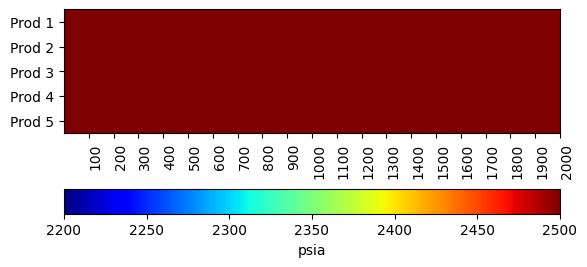

In [24]:
import matplotlib.pyplot as plt
prod_wells =['Prod {}'.format(i+1) for i in range(num_prod)]
days = ['{}'.format((i+1)*100) for i in range(len(ACTIONS))]
plt.imshow(Controls_opt[:, :num_prod].transpose())
ax = plt.gca()
ax.set_yticks(np.arange(num_prod))
ax.set_xticks(np.arange(len(ACTIONS))+0.5)
ax.set_yticklabels(labels=prod_wells)
ax.set_xticklabels(labels=days, rotation=90, ha='left')
# ax.grid(color='b', linestyle='-', linewidth=1)
cbar = plt.colorbar(orientation="horizontal")
cbar.ax.set_xlabel('psia')
# plt.colorbar()
plt.clim(2200,2500)
plt.show()

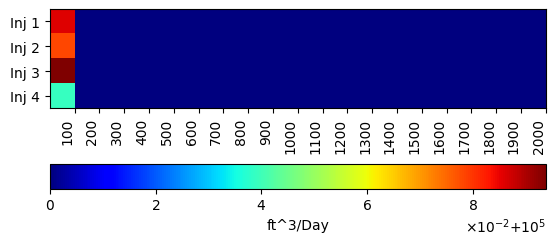

In [25]:
import matplotlib.ticker as ticker
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

inj_wells =['Inj {}'.format(i+1) for i in range(num_inj)]
days = ['{}'.format((i+1)*100) for i in range(len(ACTIONS))]
plt.imshow(Controls_opt[:, num_prod:num_well].transpose())
plt.yticks(np.arange(num_inj), labels=inj_wells)
plt.xticks(np.arange(0.5,20.5,1), labels=days, rotation=90, ha='right')
cbar = plt.colorbar(orientation="horizontal")
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.set_xlabel('ft^3/Day')
plt.show()

In [26]:
Controls_opt[:, num_prod:num_well]

array([[100000.0859375, 100000.078125 , 100000.09375  , 100000.0390625],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.       , 100000.       ],
       [100000.       , 100000.       , 100000.    

In [27]:
hf_r = h5py.File(data_dir + yobs_data)
Qrate_w = torch.tensor(np.array(hf_r.get('Qpro_w_norm_slt')).transpose((2,1,0)), dtype=torch.float32)
Qrate_g = torch.tensor(np.array(hf_r.get('Qpro_g_norm_slt')).transpose((2,1,0)), dtype=torch.float32)
BHP_inj = torch.tensor(np.array(hf_r.get('BHPinj_norm_slt')).transpose((2,1,0)), dtype=torch.float32)
hf_r.close()
yobs = torch.cat((Qrate_w,Qrate_g,BHP_inj),dim=1)

In [28]:
hf_r = h5py.File(data_dir + ctrl_data, 'r')
bhp0 = torch.tensor(np.array(hf_r.get('Pwf_norm_slt')).transpose((2,1,0)) , dtype=torch.float32)
rate0 = torch.tensor(np.array(hf_r.get('Qinj_norm_slt')).transpose((2,1,0)) , dtype=torch.float32)
hf_r.close()
controls = torch.cat((bhp0,rate0),dim=1)

In [29]:
yobs.shape

torch.Size([600, 14, 20])

In [30]:
npv_all =0
for i_time in range(yobs.shape[2]):
    alpha = np.power((1-0.05),i_time*100/365)
    Qw = yobs[:,:num_prod, i_time]*Q_diff_w+Q_min
    Qg = yobs[:,num_prod:num_prod*2, i_time]*Q_diff_g+Q_min
    Qinj_g = controls[:, num_prod:-1, i_time]*Q_diff_g+Q_min
    lf3toton =0.1167*4.536e-4 # convert lf^3 to ton 
    pv = np.sum((50-10)*lf3toton*Qinj_g.detach().cpu().numpy().squeeze())- np.sum(5*Qw.detach().cpu().numpy().squeeze()) - np.sum(50*lf3toton*Qg.detach().cpu().numpy().squeeze())
    npv_all += pv*100*alpha

In [31]:
np.max(npv_all)

-4329393110.151995

In [32]:
yobs_file_best = 'rate_norm_best2'
yobs_data_best = yobs_file_best + '.mat'

ctrl_file_best = 'controls_norm_best2'
ctrl_data_best = ctrl_file_best + '.mat'

In [33]:
hf_r_best = h5py.File(data_dir + yobs_data_best, 'r')
Qrate_w = torch.tensor(np.array(hf_r_best.get('Qpro_w_norm_best')).transpose((2,1,0)), dtype=torch.float32)
Qrate_g = torch.tensor(np.array(hf_r_best.get('Qpro_g_norm_best')).transpose((2,1,0)), dtype=torch.float32)
BHP_inj = torch.tensor(np.array(hf_r_best.get('BHPinj_norm_best')).transpose((2,1,0)), dtype=torch.float32)
hf_r_best.close()
yobs_best = torch.cat((Qrate_w,Qrate_g,BHP_inj),dim=1)

In [34]:
hf_r = h5py.File(data_dir + ctrl_data_best, 'r')
bhp0 = torch.tensor(np.array(hf_r.get('Pwf_norm_best')).transpose((2,1,0)) , dtype=torch.float32)
rate0 = torch.tensor(np.array(hf_r.get('Qinj_norm_best')).transpose((2,1,0)) , dtype=torch.float32)
hf_r.close()
controls_best = torch.cat((bhp0,rate0),dim=1)

In [35]:
npv_all =0
for i_time in range(yobs_best.shape[2]):
    alpha = np.power((1-0.05),i_time*100/365)
    Qw = yobs_best[:,:num_prod, i_time]*Q_diff_w+Q_min
    Qg = yobs_best[:,num_prod:num_prod*2, i_time]*Q_diff_g+Q_min
    Qinj_g = controls_best[:, num_prod:-1, i_time]*Q_diff_g+Q_min
    lf3toton =0.1167*4.536e-4 # convert lf^3 to ton 
    pv = np.sum((50-10)*lf3toton*Qinj_g.detach().cpu().numpy().squeeze())- np.sum(5*Qw.detach().cpu().numpy().squeeze()) - np.sum(50*lf3toton*Qg.detach().cpu().numpy().squeeze())
    npv_all += pv*100*alpha

In [36]:
npv_all

-10327732.66562316

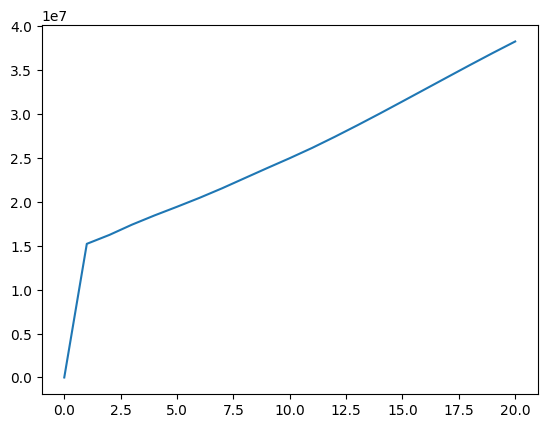

In [37]:
NPV_all =np.zeros((yobs.shape[0], yobs.shape[2]+1))
NPV = np.zeros((yobs.shape[2]+1))
for i_time in range(yobs.shape[2]):
    alpha = np.power((1-0.05),i_time*100/365)
    Qpro_w = Yobs_pred[i_time][:,:num_prod]*Q_diff_w+Q_min
    Qpro_g = Yobs_pred[i_time][:,num_prod:num_prod*2]*Q_diff_g+Q_min
    Qinj_g = ACTIONS[i_time][:, num_prod:]*Q_diff_g+Q_min
    lf3toton =0.1167*4.536e-4 # convert lf^3 to ton 
    pv = np.sum((50-10)*lf3toton*Qinj_g.detach().cpu().numpy().squeeze())- np.sum(10*Qpro_w.detach().cpu().numpy().squeeze()) - np.sum(50*lf3toton*Qpro_g.detach().cpu().numpy().squeeze())
    npv += pv*100*alpha
    NPV[i_time+1] = npv
    
    Qw = yobs[:,:num_prod, i_time]*Q_diff_w+Q_min
    Qg = yobs[:,num_prod:num_prod*2, i_time]*Q_diff_g+Q_min
    Qinj_g = controls[:, num_prod:-1, i_time]*Q_diff_g+Q_min
    pv_all = np.sum((50-10)*lf3toton*Qinj_g.detach().cpu().numpy().squeeze())- np.sum(10*Qw.detach().cpu().numpy().squeeze()) - np.sum(50*lf3toton*Qg.detach().cpu().numpy().squeeze())
    npv_all += pv_all*100*alpha
    NPV_all[:, i_time+1] = npv_all

plt.plot(NPV)
# for i in range(NPV_all.shape[0]):
#     plt.plot(NPV_all[i,:],'b')
plt.show()

In [ ]:
NPV.size

In [ ]:
plt.plot(np.arange(yobs.shape[2]+1)*100, NPV)
# for i in range(NPV_all.shape[0]):
#     plt.plot(NPV_all[i,:],'b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Days', fontsize=14)
plt.ylabel('USD', fontsize=14)
plt.show()